In [1]:
# this demo for analysing eeg power over time recorded from the backyard brains device is modified from 
# https://backyardbrains.com/experiments/files/Quantify_EEG4.py.zip

In [2]:
# import all important libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves
import csv
import pandas as pd

In [3]:
# read in the file
file = r"C:\Users\zaretska\Nextcloud\current\jupyter\backyardbrains_fft_demo\BYB_Recording_2023-03-14_09.33.00.wav"
fs, data = waves.read(file)

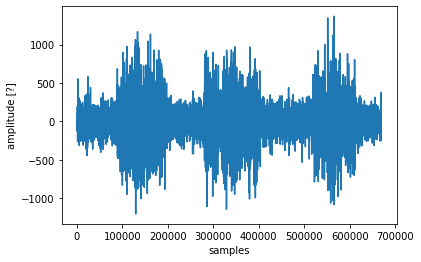

In [4]:
# plot the raw signal
plt.figure('raw data')
plt.plot(data)
plt.xlabel('samples')
plt.ylabel('amplitude [?]')
plt.show()

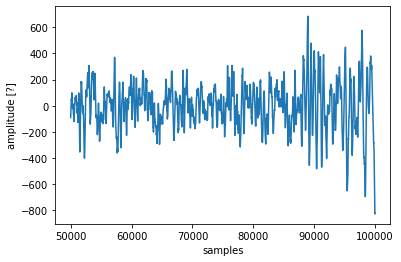

In [5]:
# plot the raw segment where the amplitude increases
plt.figure('raw data')
samples = range(50000,100001)
plt.plot(samples, data[50000:100001])
plt.xlabel('samples')
plt.ylabel('amplitude [?]')
plt.show()

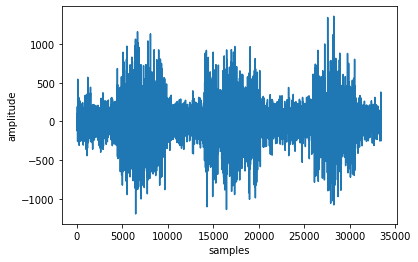

In [6]:
# resample the signal and plot it (the original data is sampled at 10000 Hz)
length_data=np.shape(data)
length_new=length_data[0]*0.05 # here we resample to 500 Hz
ld_int=int(length_new)

from scipy import signal
data_new=signal.resample(data,ld_int)

plt.figure('resampled data')
plt.plot(data_new)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.show()

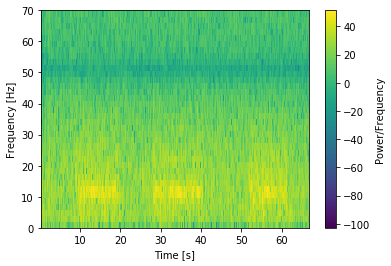

In [7]:
# calculate and plot the spectrogram over time
plt.figure('Spectrogram')
d, f, t, im = plt.specgram(data_new, NFFT= 256, Fs=500, noverlap=250)
plt.ylim(0, 70)
plt.colorbar(label= "Power/Frequency")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()

In [8]:
# save frequences as CSV
matrixf=np.array(f).T
np.savetxt('Frequencies.csv', matrixf)
df = pd.read_csv("Frequencies.csv", header=None, index_col=None)
df.columns = ["Frequencies"]
df.to_csv("Frequencies.csv", index=False)

In [9]:
# select the alpha frequency
position_vector=[]
length_f=np.shape(f)
l_row_f=length_f[0]
for i in range(0, l_row_f):
    if f[i]>=7 and f[i]<=12:
        position_vector.append(i)

In [10]:
# extract alpha over time, averaging over frequencies
length_d=np.shape(d)
l_col_d=length_d[1]
AlphaRange=[]
for i in range(0,l_col_d):
    AlphaRange.append(np.mean(d[position_vector[0]:max(position_vector)+1,i]))

In [11]:
# smooth the data    
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

(0, 66.688)

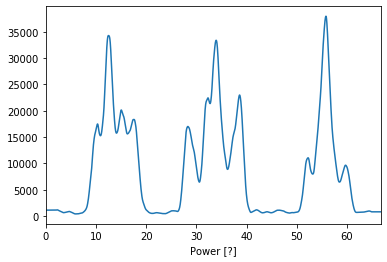

In [12]:
# plot alpha
plt.figure('AlphaRange')
y=smoothTriangle(AlphaRange, 100)
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.xlabel('Power [?]')
plt.xlim(0,max(t))

In [13]:
# save alpha as CSV
datosy=np.asarray(y)
datosyt=np.array(
       [
       datosy,
        t
        ])
with open ('datosyt.csv', 'w', newline='') as file:
   writer=csv.writer(file, dialect='excel-tab')
   writer.writerows(datosyt.T)

df = pd.read_csv("datosyt.csv", header=None, index_col=None)
df.columns = ["Power                   Time"]
df.to_csv("datosyt.csv", index=False)

Text(0, 0.5, 'AlphaPower')

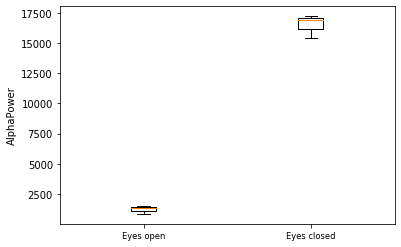

In [14]:
# now we need the vector with events
#event_file = '/Users/natalia/Music/Spike Recorder/BYB_Recording_2023-03-14_09.33.00-events.txt'
event_file = r'C:\Users\zaretska\Nextcloud\current\jupyter\backyardbrains_fft_demo\BYB_Recording_2023-03-14_09.33.00-events.txt'
event_data = np.loadtxt(event_file, comments='#', delimiter=',')
event_times = event_data[:,1]
tg = event_times.tolist()
tg.append(max(t)+1)

length_t=np.shape(t)
l_row_t=length_t[0]
eyesclosed=[]
eyesopen=[]
j=0  #initial variable to traverse tg
l=0  #initial variable to loop through the "y" data
for i in range(0, l_row_t):
    if t[i]>=tg[j]:
        
        if j%2==0:
            eyesopen.append(np.mean(datosy[l:i]))
        if j%2==1:
            eyesclosed.append(np.mean(datosy[l:i]))
        l=i
        j=j+1

        
plt.figure('DataAnalysis')
plt.boxplot([eyesopen, eyesclosed], sym = 'ko', whis = 1.5)
plt.xticks([1,2], ['Eyes open', 'Eyes closed'], size = 'small', color = 'k')
plt.ylabel('AlphaPower')


In [15]:
# do some statistics and print it
meanopen=np.mean(eyesopen)
meanclosed=np.mean(eyesclosed)
sdopen=np.std(eyesopen)
sdclosed=np.std(eyesclosed)
eyes=np.array([eyesopen, eyesclosed])

from scipy import stats
result=stats.ttest_ind(eyesopen, eyesclosed, equal_var = False)
print(result)

Ttest_indResult(statistic=-25.550971784246077, pvalue=0.00047247349738320217)
